**Run "pip install -e ." in the project root first!**

# Shap and Lime for XIR (Explaining No-Interaction Models)

### Imports

In [17]:
import warnings
warnings.filterwarnings("ignore")

import tomllib
from pathlib import Path
import numpy as np
import inflect
from collections import defaultdict
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas

from src.modules.loader.statspearls_data_loader import StatPearlsDataLoader
from src.modules.loader.medmcqa_data_loader import MedMCQADataLoader
from src.modules.loader.medmcqa_data_loader import format_medmcqa_question
from src.modules.llm.llm_client import LLMClient
from src.modules.rag.rag_engine import RAGEngine
from src.modules.rag.multihop_rag_engine import MultiHopRAGEngine
from src.modules.explainers.shap_explainer import ShapExplainer
from src.modules.explainers.lime_explainer import LimeExplainer

In [2]:
# helper function for displaying results

def display_results(explainer, explanations):

    for question_explanation in explanations:
        print(f"\n \33[1m===== Results for Question: =====\33[0m \n {question_explanation['question']}\n")

        print(f"\033[1mQuery for Hop_1\033[0m:\n{question_explanation['explanation']['hop_1'][0]['query']}\n")
        hop_1 = question_explanation["explanation"]["hop_1"]
        for i, context_doc in enumerate(hop_1):
            display(HTML( f"<h3>Document {i + 1}</h3>"))
            explainer.plot_text_heatmap(context_doc)
            explainer.plot_bar(context_doc)

        print(f"\n \33[1m------------------------------------\33[0m")
        print(f"\n \033[1mQuery for Hop_2\033[0m:\n{question_explanation['explanation']['hop_2'][0]['query']}\n")
        hop_2 = question_explanation["explanation"]["hop_2"]
        for i, context_doc in enumerate(hop_2):
            display(HTML( f"<h3>Document {i + 1}</h3>"))
            explainer.plot_text_heatmap(context_doc)
            explainer.plot_bar(context_doc)

In [3]:
import pickle
import os

# --- SAVING ---
def save_explanations(explanations, filename="explanations.pkl"):
    full_path = os.path.join("eval/shap_lime", filename)
    with open(full_path, "wb") as f:
        pickle.dump(explanations, f)
    print(f"Saved explanations to {filename}")

# --- LOADING ---
def load_explanations(filename="explanations.pkl"):
    full_path = os.path.join("eval/shap_lime", filename)
    with open(full_path, "rb") as f:
        return pickle.load(f)

### Setup

It is crucial to select the fitting Background image for SHAP. Fortunately this research was already conducted by [Fernando et. al.](https://arxiv.org/abs/1907.06484). The selection is dependent on the NRM used for the retrieval, tho performances are fairly similar for each NRM.

![Performance Metrics Background Images](img/image.png)

**ATTENTION**: We currently use "sentence-transformers/all-MiniLM-L6-v2" as the embedding model. This is a simple Bert based Bi-Encoder and no NRM. A NRM is a Reranker, using both query and document together to generate a relevance score instead of an embedding vector. These models **can** yield significantly better matching results for query and documents, but to the drawback of computational cost and time.

The **KernelExplainer** used for Shap here is similar to LIME, because it explains a local instance using the set of locally perturbated instances and fits a linear model on the set. It differs by the way it approximates the values if that model, it uses the approximation of shapely-values, whereas LIME uses a simple exponential kernel.

## 1. Retrieval Experiment

### Data setup

In [4]:
project_root = next((p for p in [Path.cwd()] + list(Path.cwd().parents) if (p / 'src').exists()), None)

config_path = project_root / "config.toml"
config = {}

if config_path.exists():
    with open(config_path, "rb") as f:
        config = tomllib.load(f)

medmcqa_config = config.get("medmcqa") or {}
rag_config = config.get("rag") or {}
llm_config = config.get("llm") or {}

llm_model = llm_config.get("model")
llm_provider = llm_config.get("provider")

question_ids = medmcqa_config.get("kg_capable") or {}

client = LLMClient(provider=llm_provider, model_name=llm_model)

SPLIT = medmcqa_config.get("split", "val")
PERSIST_DIR = project_root / "data" / "vector_db_statpearls"
NUM_HOPS = rag_config.get('n_hops', 2)
NUM_DOCUMENTS = 50

In [5]:
stat_loader = StatPearlsDataLoader(root_dir=str(project_root / "data"))
documents, stats = stat_loader.setup()

med_loader = MedMCQADataLoader()
questions = med_loader.setup(split=SPLIT, as_documents=False, ids=question_ids) #NOTE: Only one question due to computation limitation

### Setup RAG-Engine and Multihop RAG-Engine

In [6]:
rag_engine = RAGEngine(persist_dir=str(PERSIST_DIR))
rag_engine.setup(documents=documents, k=4)

multi_hop = MultiHopRAGEngine(rag_engine=rag_engine, llm_client=client, num_hops=2)

Loading existing vector store from /data/home/pon34391/xai-rag/data/vector_db_statpearls...
RagEngine ready.
Connecting to local Ollama (gemma3:4b)...


Setup and run Multi-Hop Retrieval experiment. For this we will select a random set of questions from the dataset (question_ids in the config).

In [8]:
results = []
for question in questions:
    question_text = format_medmcqa_question(question)
    if not question_text:
        continue

    trace, _ = multi_hop.run_and_trace(question_text)
    final_answer = (trace.get("final_answer") or "").strip()

    results.append(
        {
            "question": question_text,
            "final_answer": final_answer,
            "trace": trace
        }
    )

--- Starting Multi-Hop Search for: 'Childhood osteopetrosis is characterized by – a) B/L frontal bossingb) Multiple # (fracture)c) Hepatosplenomegalyd) Cataracte) Mental retardation

Options:
A: bc
B: c
C: ac
D: ad' ---

[ Hop 1 ]
Executing search with query: 'Childhood osteopetrosis is characterized by – a) B/L frontal bossingb) Multiple # (fracture)c) Hepatosplenomegalyd) Cataracte) Mental retardation

Options:
A: bc
B: c
C: ac
D: ad'


Generating next query...

[ Hop 2 ]
Executing search with query: '"mucopolysaccharidoses symptoms"'

Generating final answer...

--- Multi-Hop Search Complete. Final Answer: Based on the provided information, the answer is A. bc ---
--- Multi-Hop Context: 

 ('<doc id="chunk-1-1" from_hop="1" search_query="Childhood osteopetrosis is characterized by – a) B/L frontal bossingb) Multiple # (fracture)c) Hepatosplenomegalyd) Cataracte) Mental retardation\n\nOptions:\nA: bc\nB: c\nC: ac\nD: ad">\n[Document(id=\'1ac5cc03-8701-4e84-8d25-60df0e43b58d\', metadata={\'topic_name\': \'Nonsyndromic Craniosynostosis.\', \'title\': \'Nonsyndromic Craniosynostosis.\', \'chunk_id\': \'3dd91425ea7f0cfb4744b5077a57b513e3c9f94d4489e9f38e2cc58179cd0d66\', \'source\': \'statpearls\', \'source_filename\': \'article-126818.nxml\', \'chunk_index\': 24, \'split\': \'repo\'}, page_content=\'Beta-glucuronidase deficiency Mucopolysaccharidosis Mucolipidosis III X-linked hypophosphatemia 1-alpha hydroxylase deficien

In [9]:
save_explanations(results, "multihop_results.pkl")

Saved explanations to multihop_results.pkl


## 2. Shap Explanations

We can select a Key for which Document to explain:
1. "highest_ranked_document"
2. "lowest_ranked_document"
3. "context_documents"

For Shap we will investigate different strategies (also mentioned in the paper) for the background image:
1. Zero Embeddings indicating missing values
2. (Average Token Embeddings across the Document-> results in zeros too)
3. IDF (lowest) -> For this we will create a dataset of Low IDF from a representative sample of all documents (during \_\_init\_\_)

We will now explain the context documents passed to the LLM for every hop. We will do this for every question.

In [7]:
shap_explainer = ShapExplainer(rag_engine=rag_engine, documents=documents, idf_top_k=100)  # pass documents for IDF calculation

Loading tokenizer for: sentence-transformers/all-MiniLM-L6-v2
Calculating IDF for 13922 documents...
Background Vocabulary (Lowest IDF): ['the', 'and', 'of', 'to', 'in', 'is', 'with', 'for', 'or', 'be', 'are', 'as', 'that', 'on', 'an', 'this', 'patients', 'can', 'by', 'patient', 'may', 'from', 'it', 'have', 'not', 'at', 'should', 'also', 'has', 'which', 'these', 'treatment', 'such', 'other', 'more', 'when', 'include', 'disease', 'pain', 'most', 'used', 'if', 'risk', 'there', 'their', 'than', 'use', 'clinical', 'due', 'however', 'been', 'care', 'but', 'any', 'including', 'after', 'who', 'all', 'associated', 'multiple', 'therapy', 'during', 'they', 'common', '10', 'into', 'medical', 'team', 'while', 'one', 'high', 'between', 'diagnosis', 'management', 'chronic', 'outcomes', 'its', 'must', 'healthcare', 'cases', 'imaging', 'no', 'following', 'some', 'often', 'studies', 'within', 'symptoms', 'will', 'increased', 'before', 'physical', 'using', 'evaluation', 'significant', 'both', 'through',

In [13]:
background = "Low-IDF" # or "Zero"
explained_doc_key = "context_documents"
shap_explanations = []

for i, result in enumerate(results):
    print(f"\nExplaining documents for question {i+1}")
    explanation = shap_explainer.explain(result["trace"], explained_doc_key=explained_doc_key, background=background)

    shap_explanations.append({"question": result["question"],
                         "final_answer": result["final_answer"],
                         "explanation": explanation,
                         "background": background})



Explaining documents for question 1
--- Shap Explaining Hop 1 (Background: Low-IDF) ---
- Explaining Doc 1/4 -


- Explaining Doc 2/4 -
- Explaining Doc 3/4 -
- Explaining Doc 4/4 -
--- Shap Explaining Hop 2 (Background: Low-IDF) ---
- Explaining Doc 1/4 -
- Explaining Doc 2/4 -
- Explaining Doc 3/4 -
- Explaining Doc 4/4 -

Explaining documents for question 2
--- Shap Explaining Hop 1 (Background: Low-IDF) ---
- Explaining Doc 1/4 -
- Explaining Doc 2/4 -
- Explaining Doc 3/4 -
- Explaining Doc 4/4 -
--- Shap Explaining Hop 2 (Background: Low-IDF) ---
- Explaining Doc 1/4 -
- Explaining Doc 2/4 -
- Explaining Doc 3/4 -
- Explaining Doc 4/4 -

Explaining documents for question 3
--- Shap Explaining Hop 1 (Background: Low-IDF) ---
- Explaining Doc 1/4 -
- Explaining Doc 2/4 -
- Explaining Doc 3/4 -
- Explaining Doc 4/4 -
--- Shap Explaining Hop 2 (Background: Low-IDF) ---
- Explaining Doc 1/4 -
- Explaining Doc 2/4 -
- Explaining Doc 3/4 -
- Explaining Doc 4/4 -

Explaining documents for question 4
--- Shap Explaining Hop 1 (Background: Low-IDF) ---
- Explaining Doc 1/4 -
- Explaining Doc 2/4 -
- 

In [14]:
# save the explanations
save_explanations(shap_explanations, filename="shap_explanations.pkl")

Saved explanations to shap_explanations.pkl


In [ ]:
# for reloading to save on cumputation time
shap_explanations = load_explanations("shap_explanations.pkl")

Plot the results.


 ===== Results for Question: ===== 
 Childhood osteopetrosis is characterized by – a) B/L frontal bossingb) Multiple # (fracture)c) Hepatosplenomegalyd) Cataracte) Mental retardation

Options:
A: bc
B: c
C: ac
D: ad

Query for Hop_1:
Childhood osteopetrosis is characterized by – a) B/L frontal bossingb) Multiple # (fracture)c) Hepatosplenomegalyd) Cataracte) Mental retardation

Options:
A: bc
B: c
C: ac
D: ad



Base Score (Intercept): 0.1548 | Predicted Score: 0.5317 | Actual Score: 0.5317


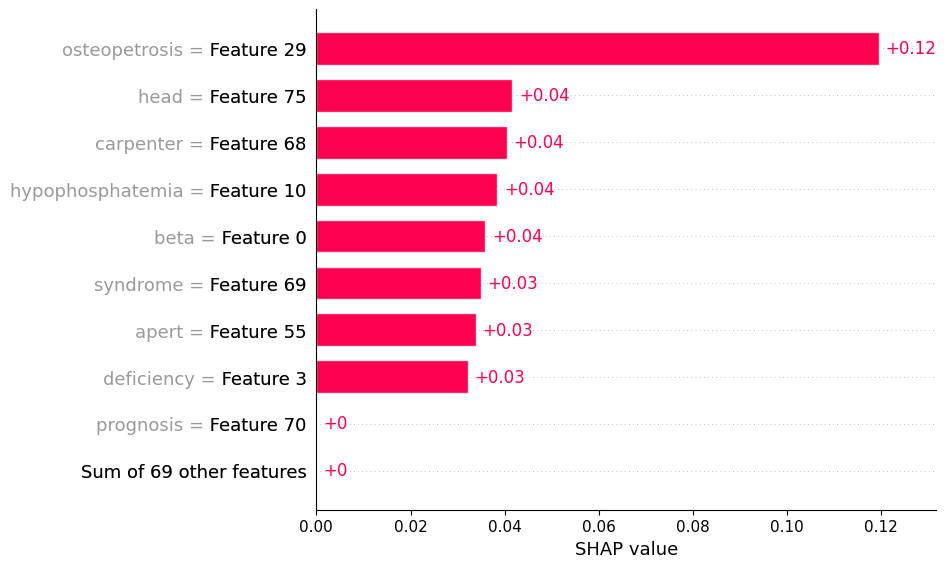

Base Score (Intercept): 0.1629 | Predicted Score: 0.5141 | Actual Score: 0.5141


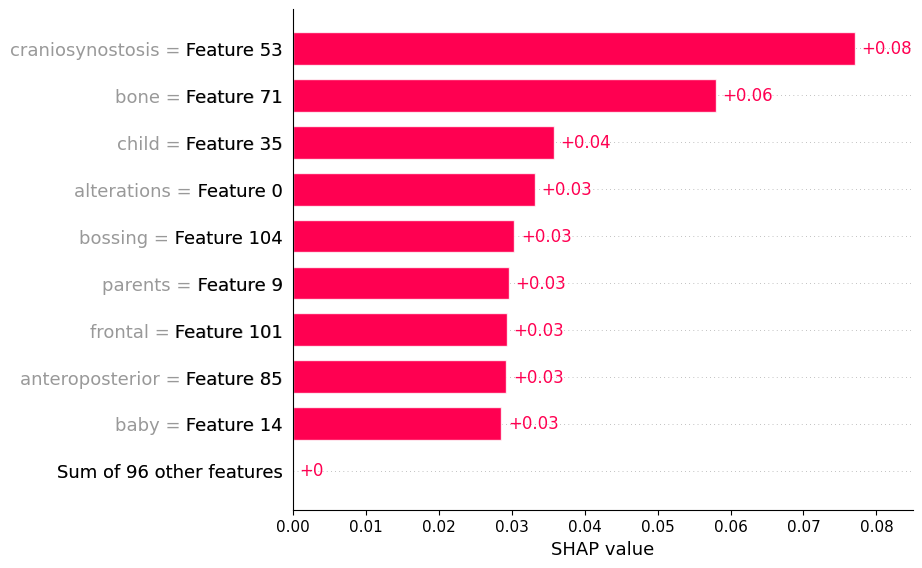

Base Score (Intercept): 0.1915 | Predicted Score: 0.4849 | Actual Score: 0.4849


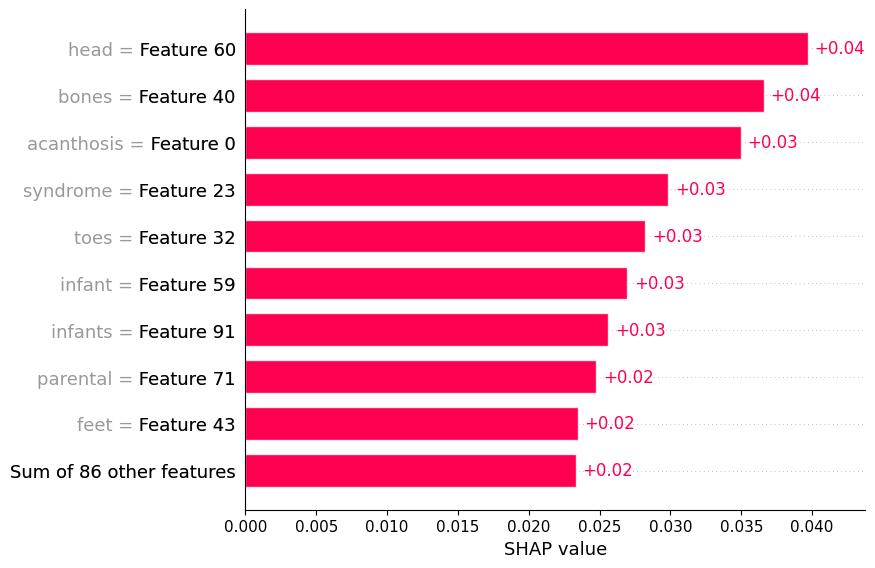

Base Score (Intercept): 0.1419 | Predicted Score: 0.4823 | Actual Score: 0.4823


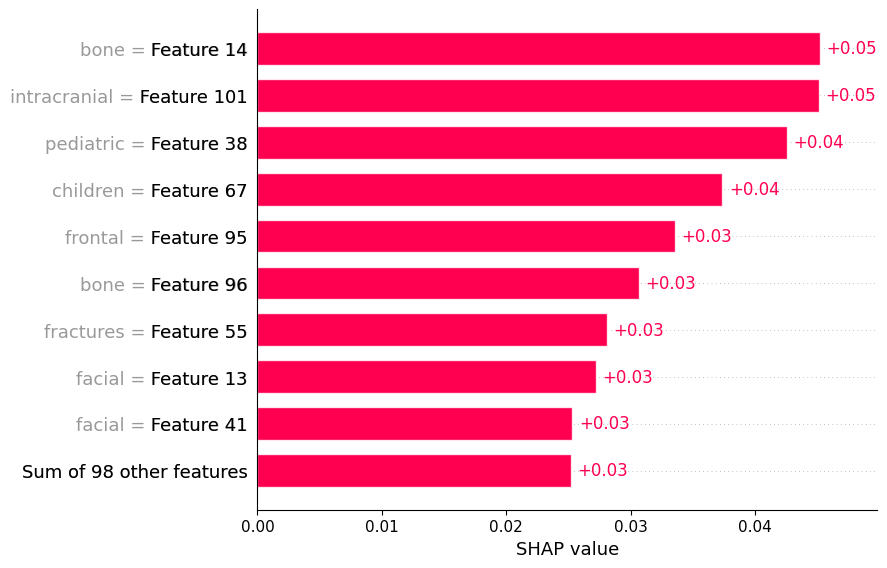


 ------------------------------------

 Query for Hop_2:
Childhood osteopetrosis symptoms



Base Score (Intercept): 0.0404 | Predicted Score: 0.5382 | Actual Score: 0.5382


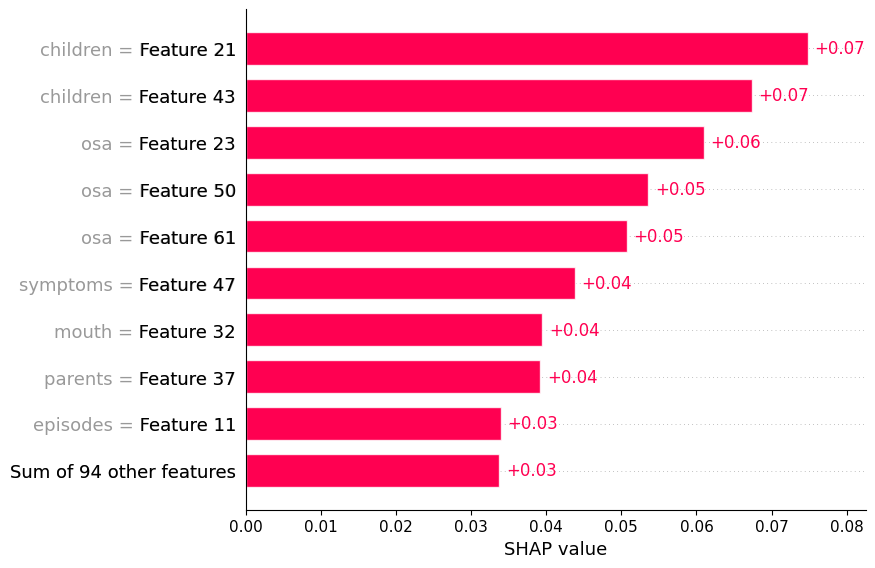

Base Score (Intercept): 0.1623 | Predicted Score: 0.5026 | Actual Score: 0.5026


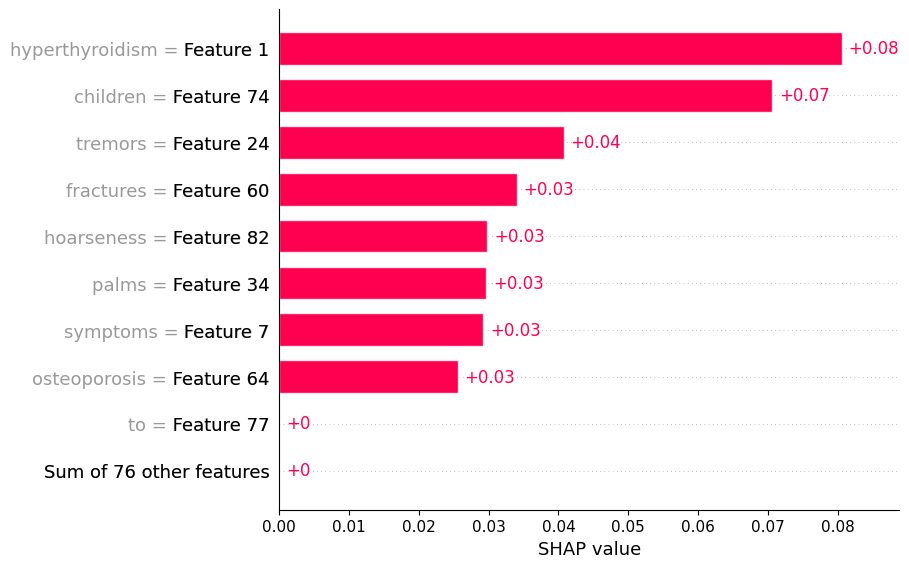

Base Score (Intercept): 0.0731 | Predicted Score: 0.4542 | Actual Score: 0.4542


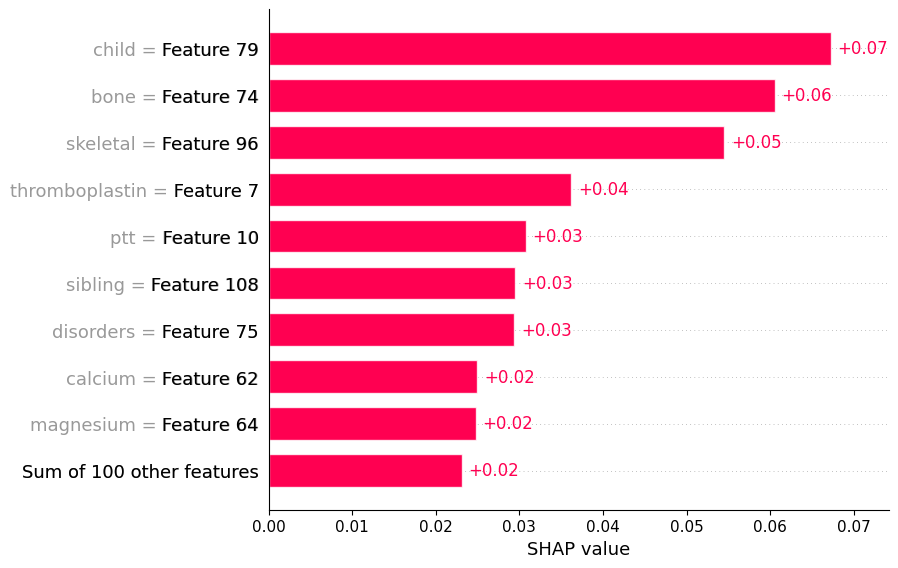

Base Score (Intercept): 0.1375 | Predicted Score: 0.4347 | Actual Score: 0.4347


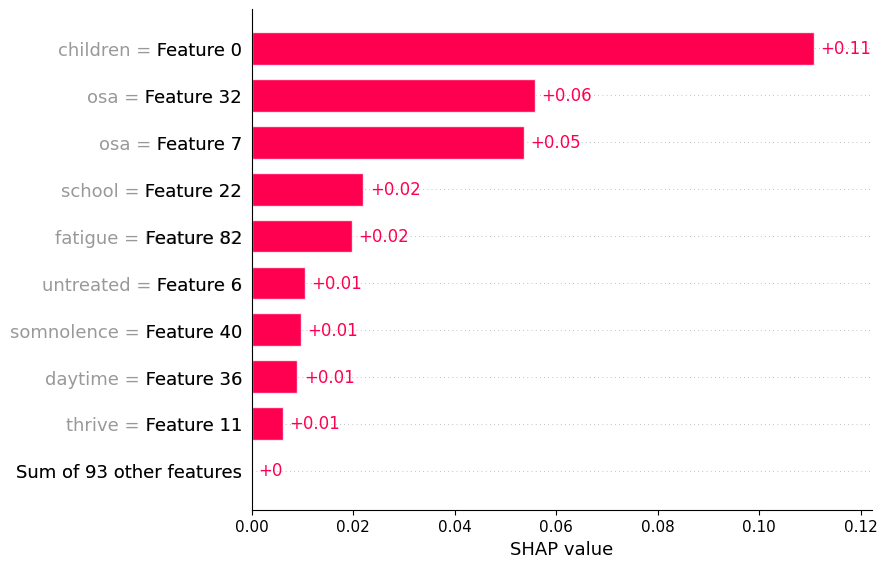


 ===== Results for Question: ===== 
 The triad of hypertension, bradycardia and irregular respiration is seen in:

Options:
A: Cushing's reflex
B: Bezold-Zarisch reflex
C: Herring-Bruer reflex
D: Bainbridge's reflex

Query for Hop_1:
The triad of hypertension, bradycardia and irregular respiration is seen in:

Options:
A: Cushing's reflex
B: Bezold-Zarisch reflex
C: Herring-Bruer reflex
D: Bainbridge's reflex



Base Score (Intercept): 0.1543 | Predicted Score: 0.5118 | Actual Score: 0.5118


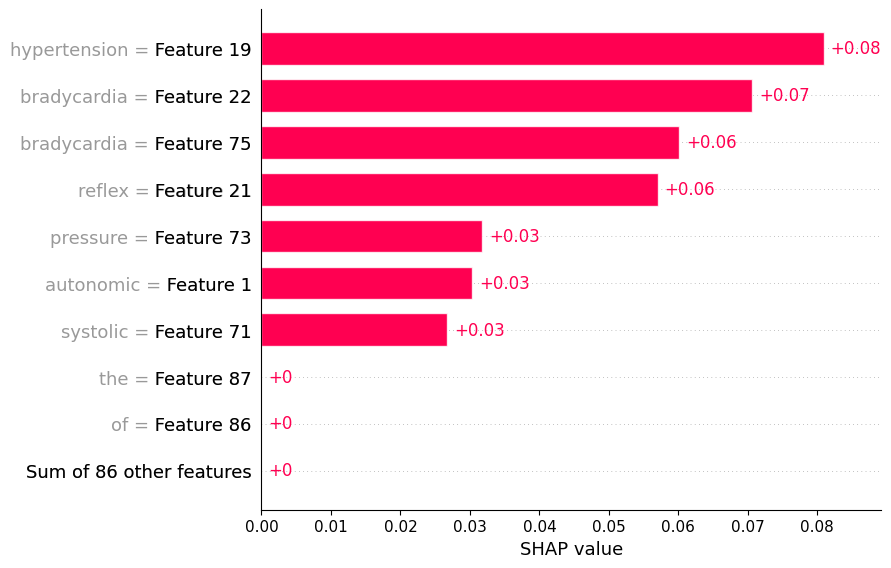

Base Score (Intercept): 0.1521 | Predicted Score: 0.4917 | Actual Score: 0.4917


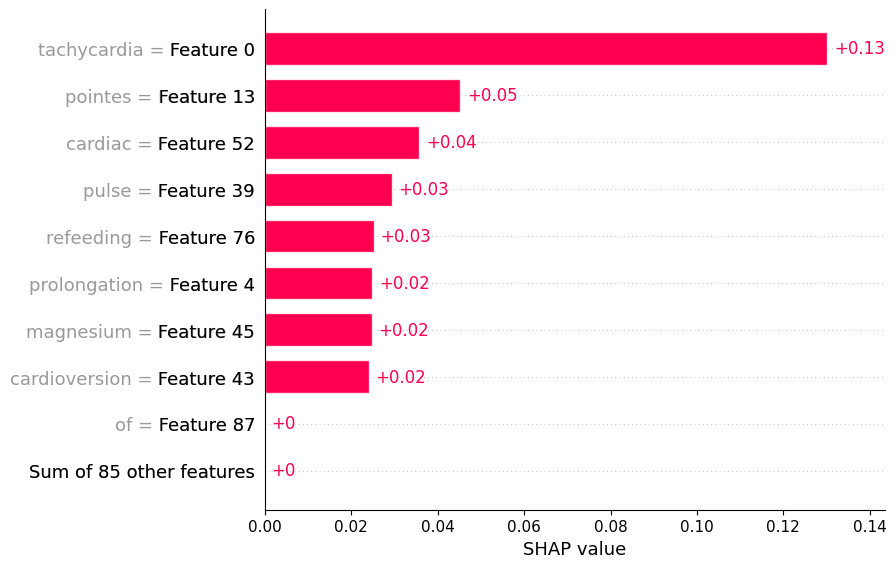

Base Score (Intercept): 0.2014 | Predicted Score: 0.4684 | Actual Score: 0.4684


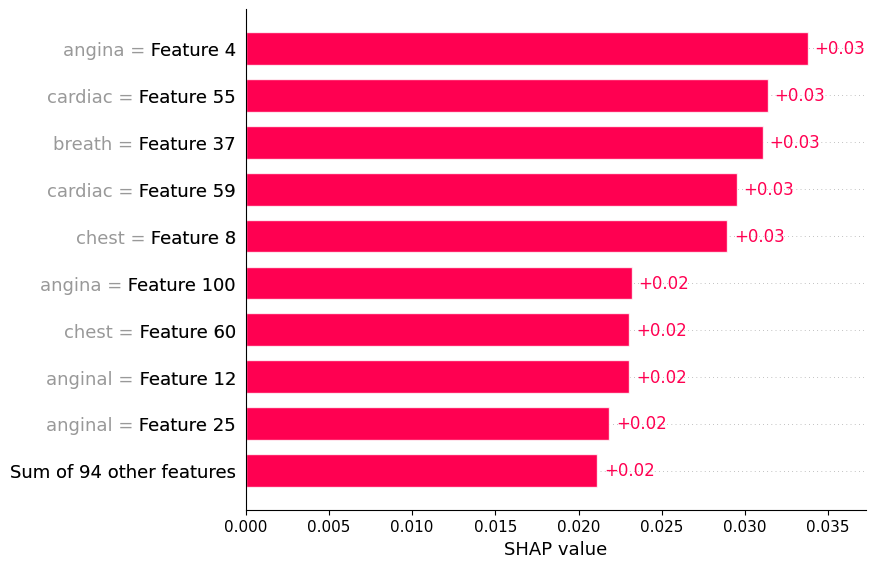

Base Score (Intercept): 0.2395 | Predicted Score: 0.4634 | Actual Score: 0.4634


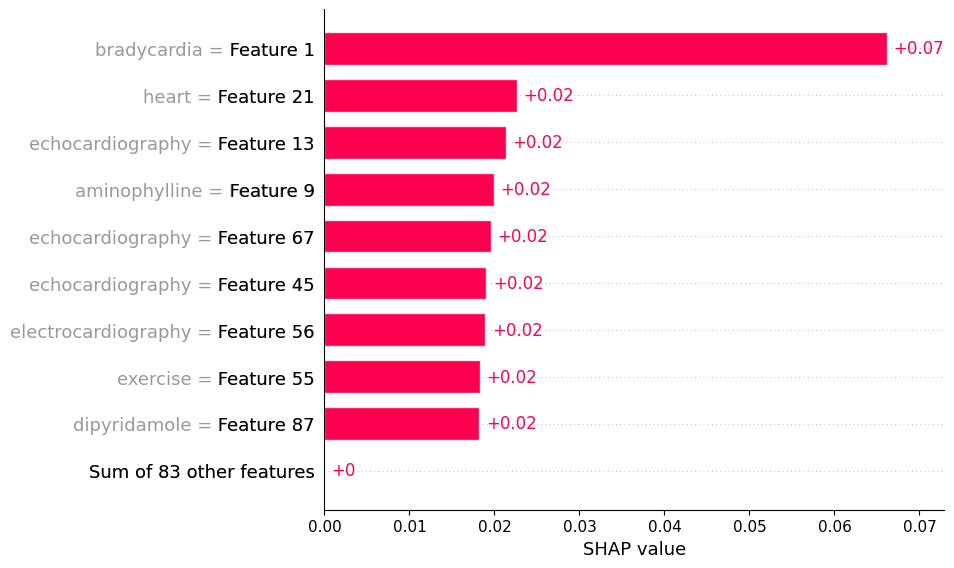


 ------------------------------------

 Query for Hop_2:
“Bezold-Zarisch reflex symptoms”



Base Score (Intercept): 0.1915 | Predicted Score: 0.5387 | Actual Score: 0.5387


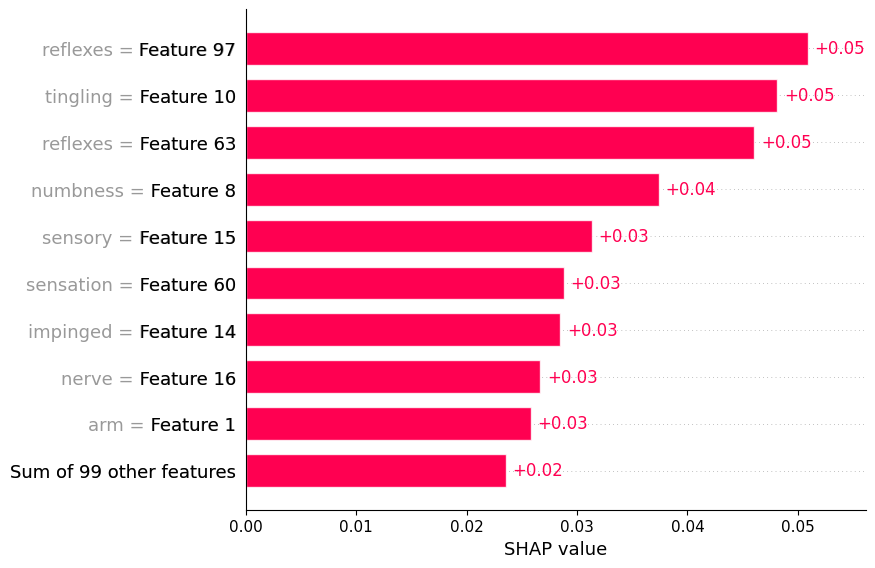

Base Score (Intercept): 0.1501 | Predicted Score: 0.5321 | Actual Score: 0.5321


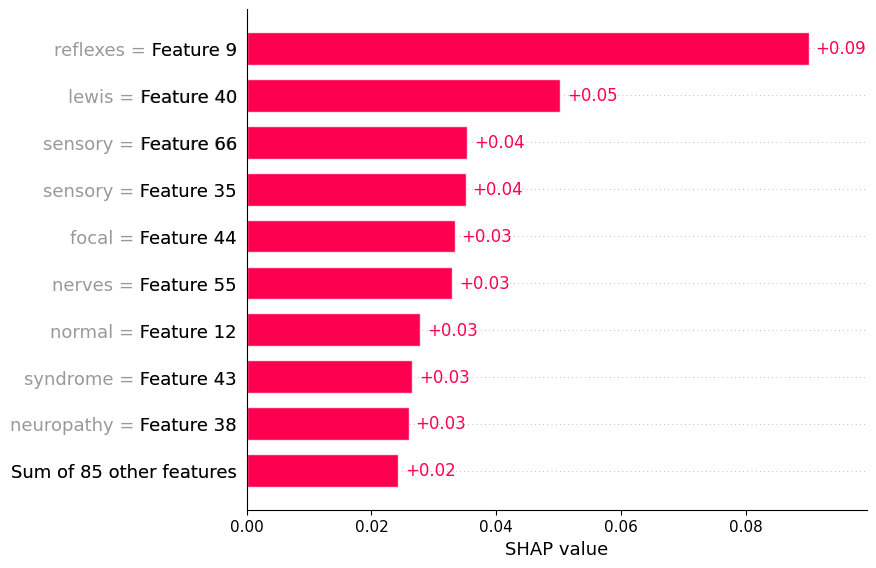

Base Score (Intercept): 0.1996 | Predicted Score: 0.4981 | Actual Score: 0.4981


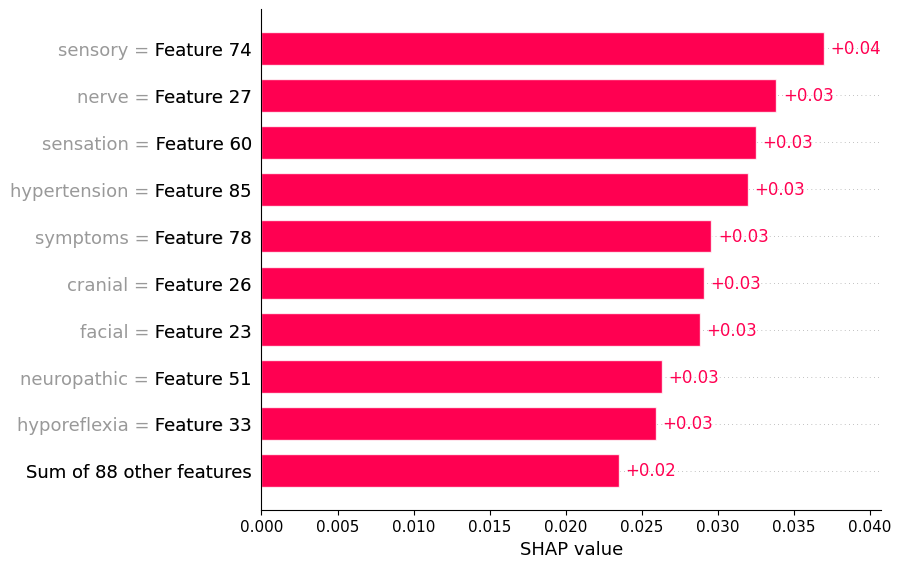

Base Score (Intercept): 0.2539 | Predicted Score: 0.4908 | Actual Score: 0.4908


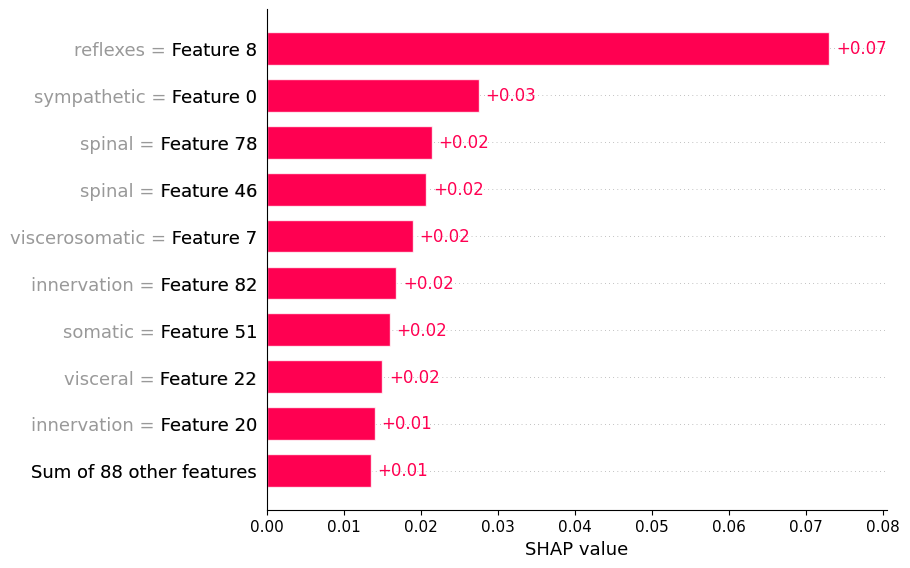

In [48]:
# plot two example questions
display_results(shap_explainer, shap_explanations[:2])

Because all Documents in the Database are part of a medical terminology, it's unlikely to find tokens with shap, that negatively impact the cosine similarity. This would more likely be found in a ColBert based RAG-System.

## 3. Lime Explanations

Explaining all documents passed to the context for every question using LimeTextExplainer.

In [9]:
lime_explainer = LimeExplainer(rag_engine=rag_engine)

In [31]:
explained_doc_key = "context_documents"
lime_explanations = []

for i, result in enumerate(results):
    print(f"\nExplaining documents for question {i+1}")
    explanation = lime_explainer.explain(result["trace"], explained_doc_key=explained_doc_key)

    lime_explanations.append({"question": result["question"],
                         "final_answer": result["final_answer"],
                         "explanation": explanation})


Explaining documents for question 1
--- LIME Explaining Hop 1 ---
- Explaining Doc 1/4 -
- Explaining Doc 2/4 -
- Explaining Doc 3/4 -
- Explaining Doc 4/4 -
--- LIME Explaining Hop 2 ---
- Explaining Doc 1/4 -
- Explaining Doc 2/4 -
- Explaining Doc 3/4 -
- Explaining Doc 4/4 -

Explaining documents for question 2
--- LIME Explaining Hop 1 ---
- Explaining Doc 1/4 -
- Explaining Doc 2/4 -
- Explaining Doc 3/4 -
- Explaining Doc 4/4 -
--- LIME Explaining Hop 2 ---
- Explaining Doc 1/4 -
- Explaining Doc 2/4 -
- Explaining Doc 3/4 -
- Explaining Doc 4/4 -

Explaining documents for question 3
--- LIME Explaining Hop 1 ---
- Explaining Doc 1/4 -
- Explaining Doc 2/4 -
- Explaining Doc 3/4 -
- Explaining Doc 4/4 -
--- LIME Explaining Hop 2 ---
- Explaining Doc 1/4 -
- Explaining Doc 2/4 -
- Explaining Doc 3/4 -
- Explaining Doc 4/4 -

Explaining documents for question 4
--- LIME Explaining Hop 1 ---
- Explaining Doc 1/4 -
- Explaining Doc 2/4 -
- Explaining Doc 3/4 -
- Explaining Doc 4/4 

In [32]:
# save the explanations
save_explanations(lime_explanations, filename="lime_explanations.pkl")

Saved explanations to lime_explanations.pkl


In [ ]:
# for reloading to save on cumputation time
lime_explanations = load_explanations("lime_explanations.pkl")


 ===== Results for Question: ===== 
 Childhood osteopetrosis is characterized by – a) B/L frontal bossingb) Multiple # (fracture)c) Hepatosplenomegalyd) Cataracte) Mental retardation

Options:
A: bc
B: c
C: ac
D: ad

Query for Hop_1:
Childhood osteopetrosis is characterized by – a) B/L frontal bossingb) Multiple # (fracture)c) Hepatosplenomegalyd) Cataracte) Mental retardation

Options:
A: bc
B: c
C: ac
D: ad



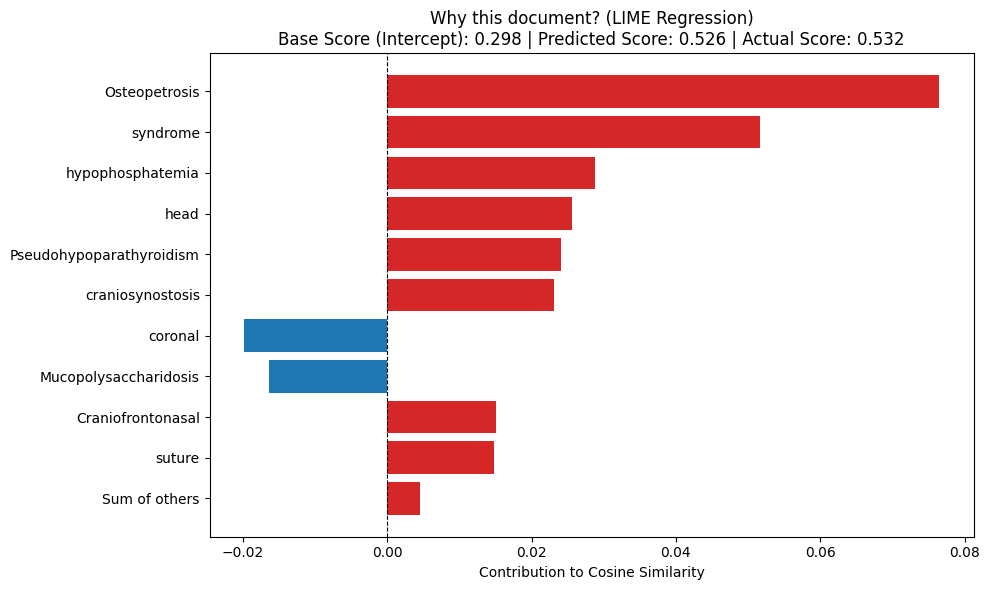

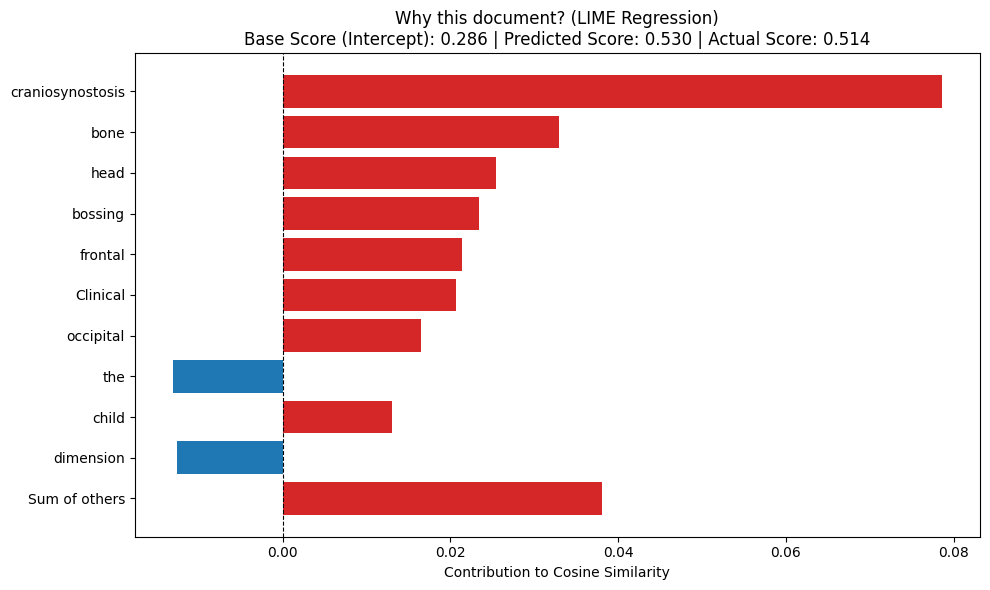

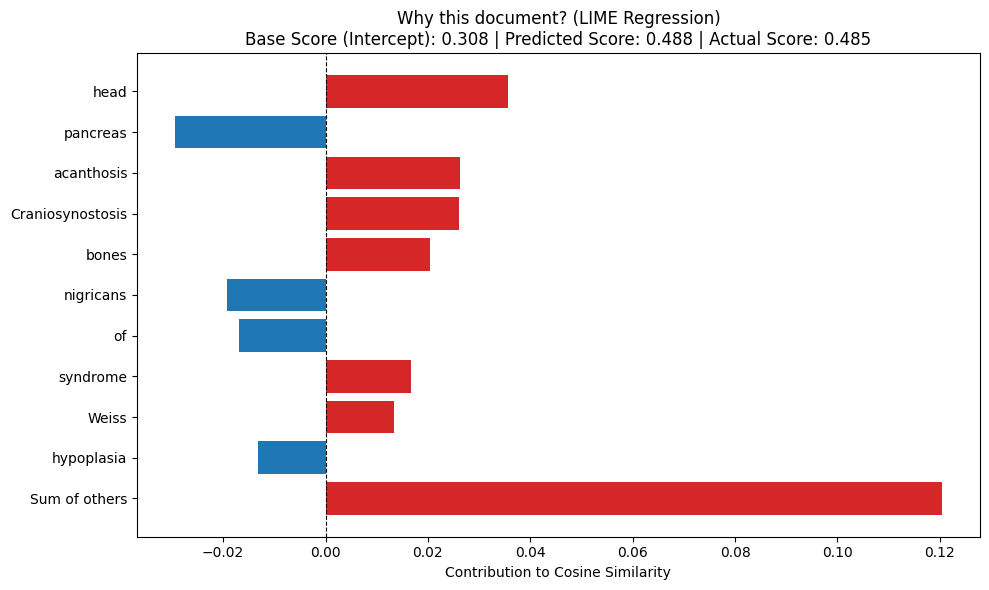

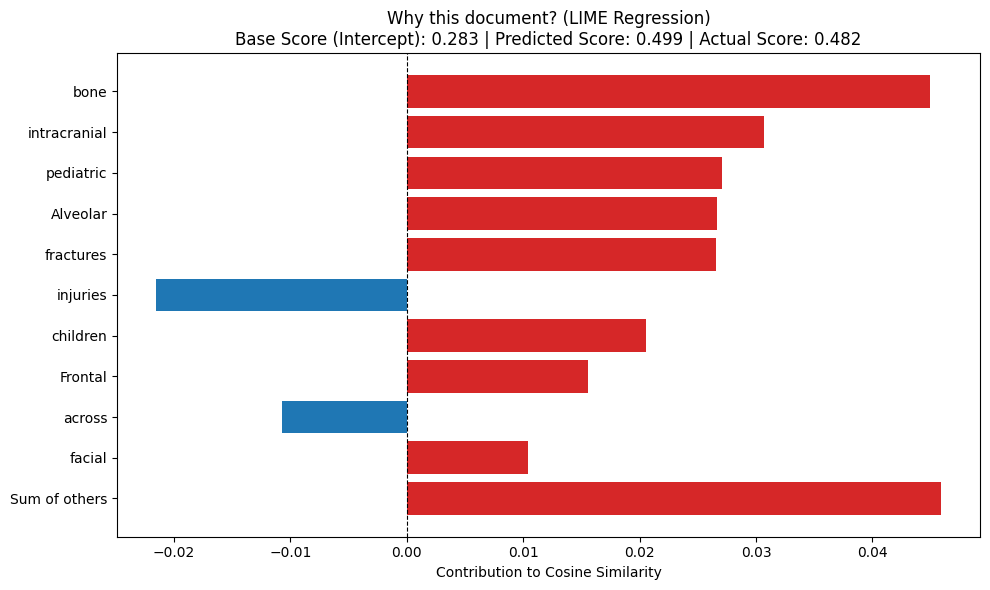


 ------------------------------------

 Query for Hop_2:
"mucopolysaccharidoses symptoms"



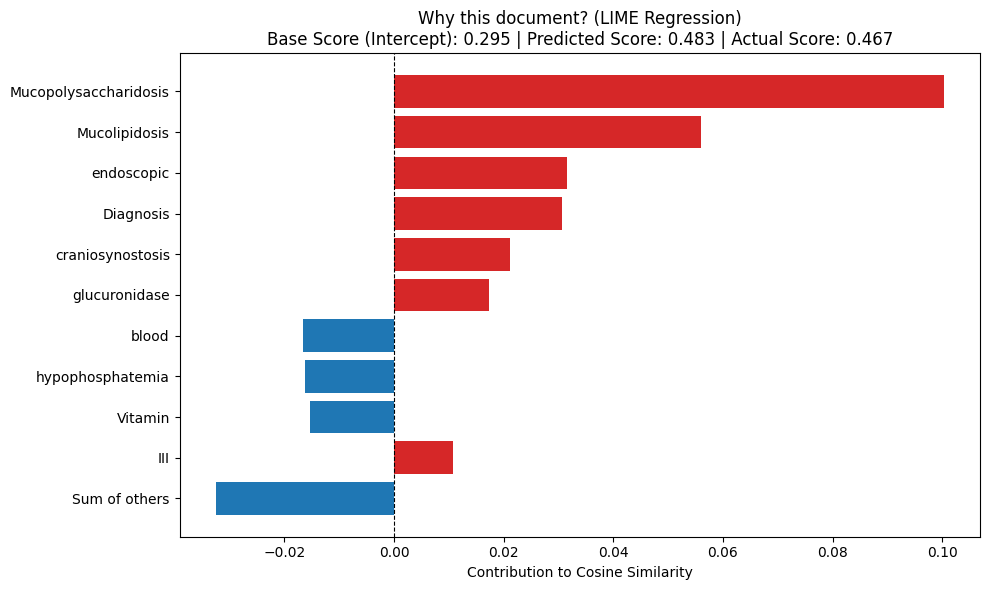

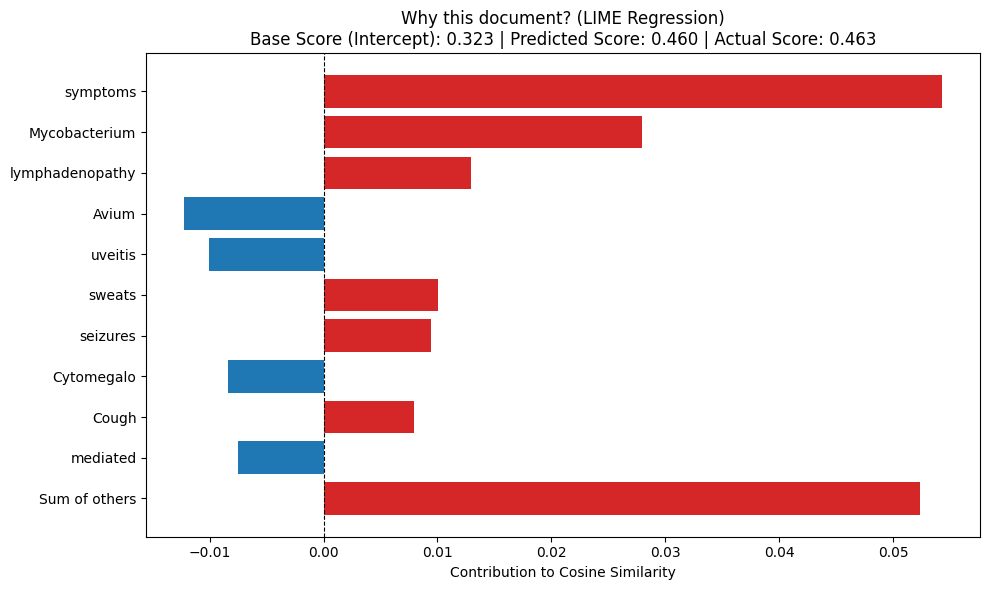

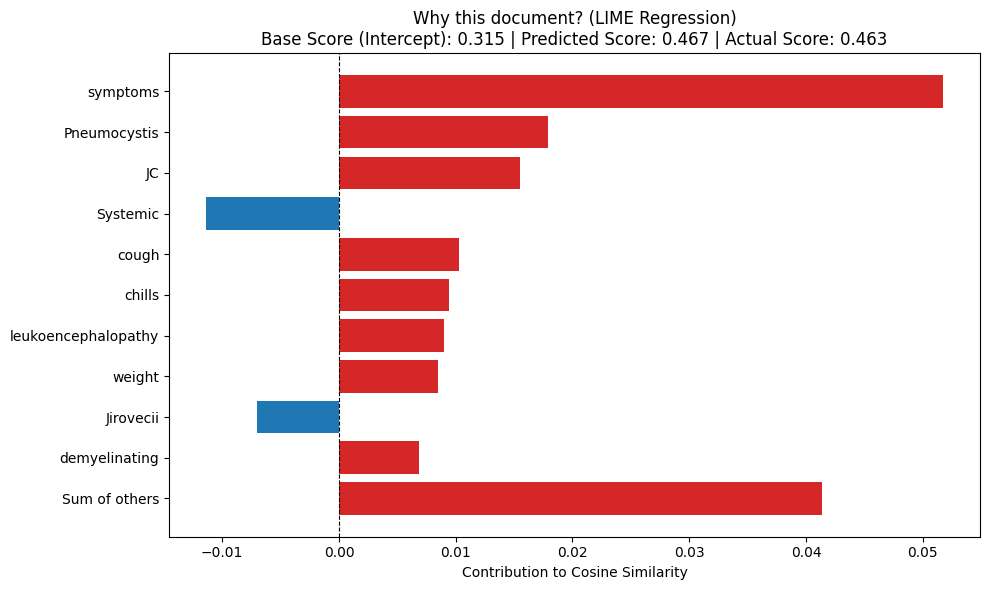

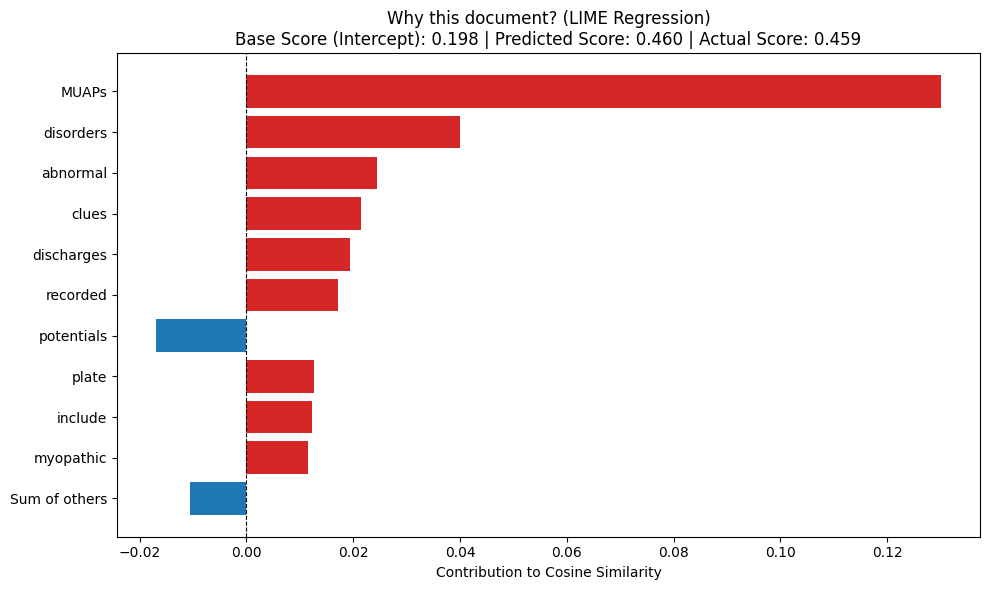


 ===== Results for Question: ===== 
 The triad of hypertension, bradycardia and irregular respiration is seen in:

Options:
A: Cushing's reflex
B: Bezold-Zarisch reflex
C: Herring-Bruer reflex
D: Bainbridge's reflex

Query for Hop_1:
The triad of hypertension, bradycardia and irregular respiration is seen in:

Options:
A: Cushing's reflex
B: Bezold-Zarisch reflex
C: Herring-Bruer reflex
D: Bainbridge's reflex



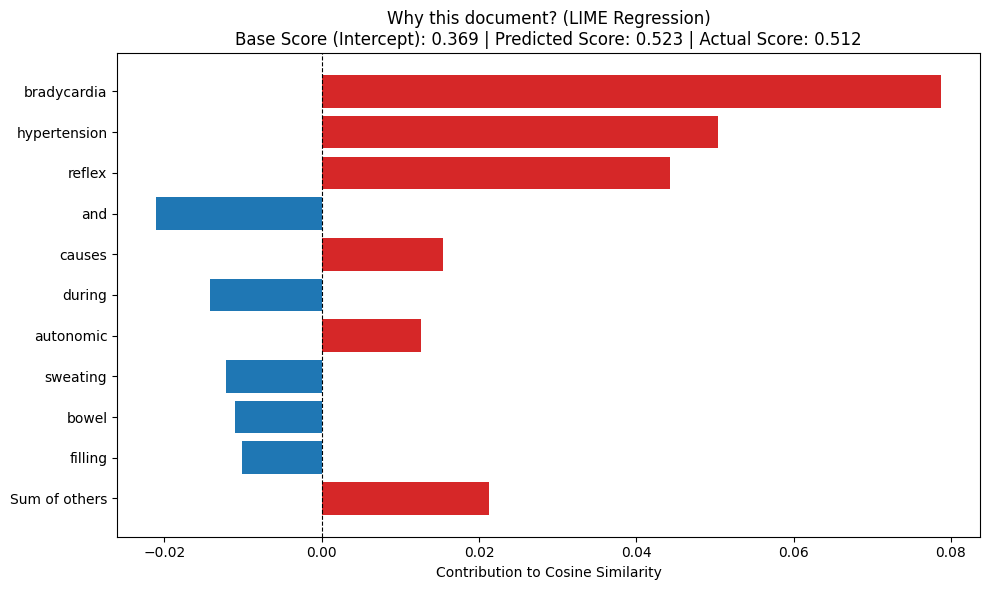

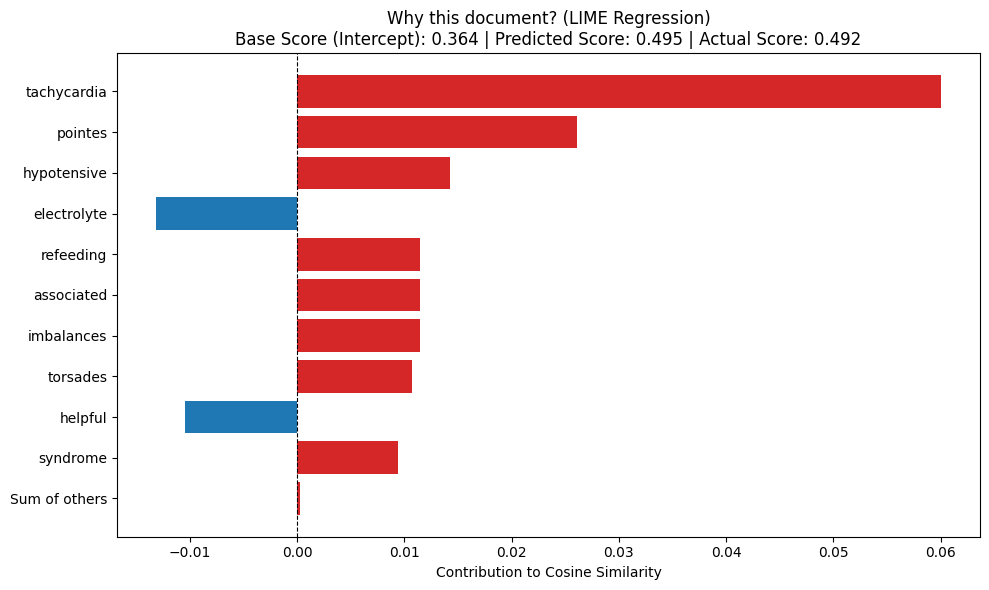

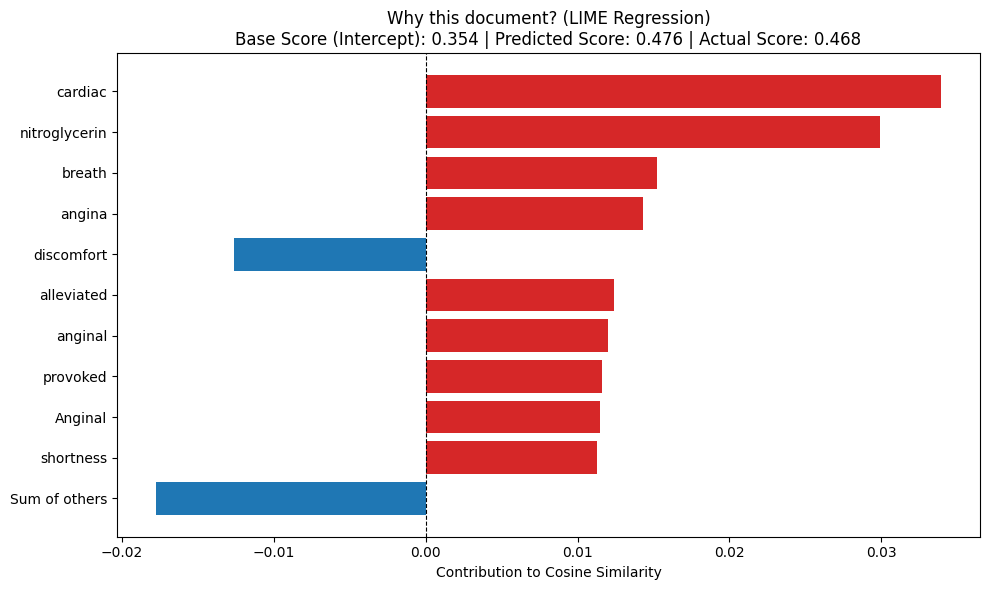

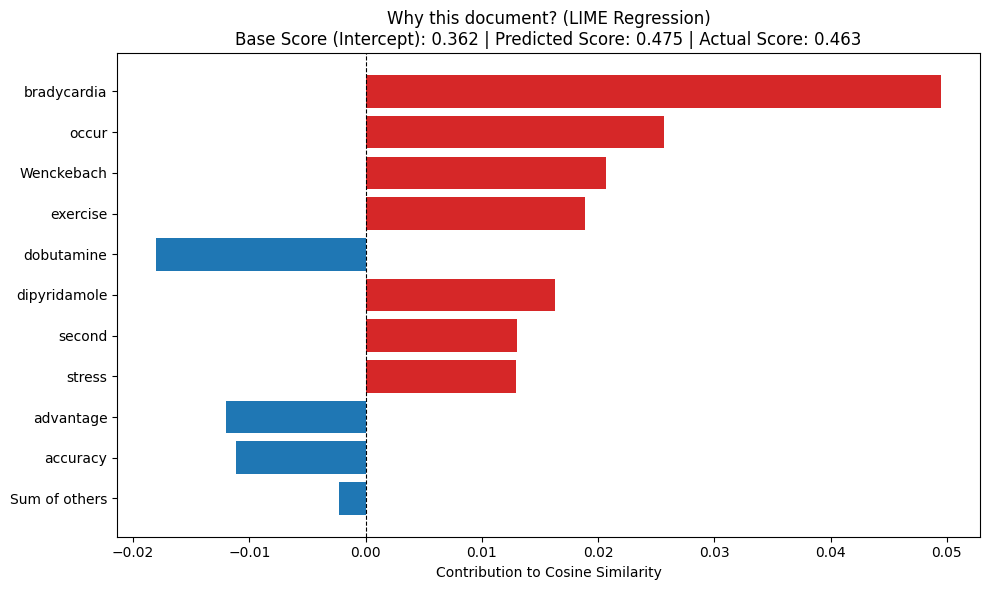


 ------------------------------------

 Query for Hop_2:
“Bezold-Zarisch reflex symptoms”



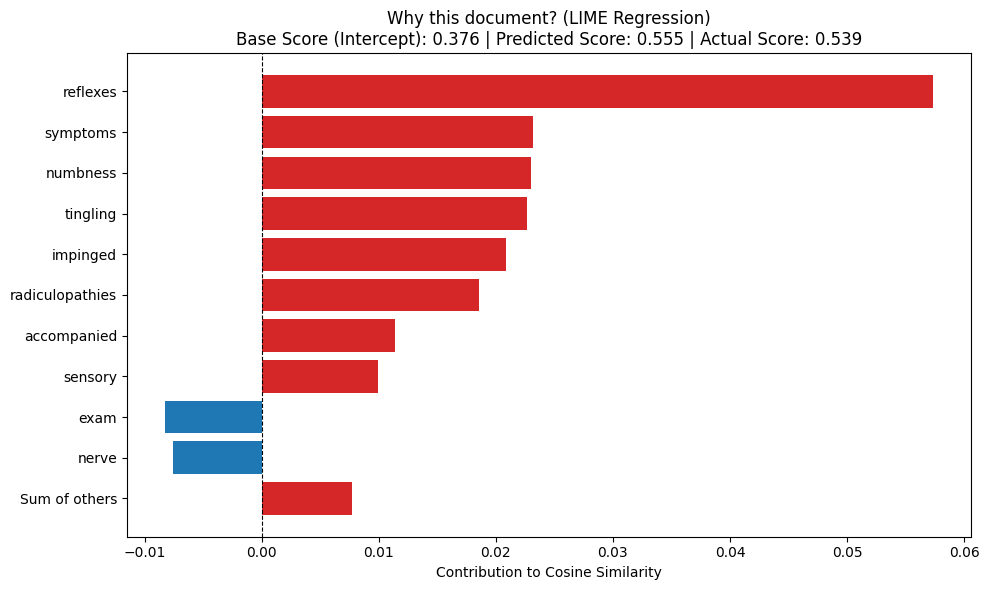

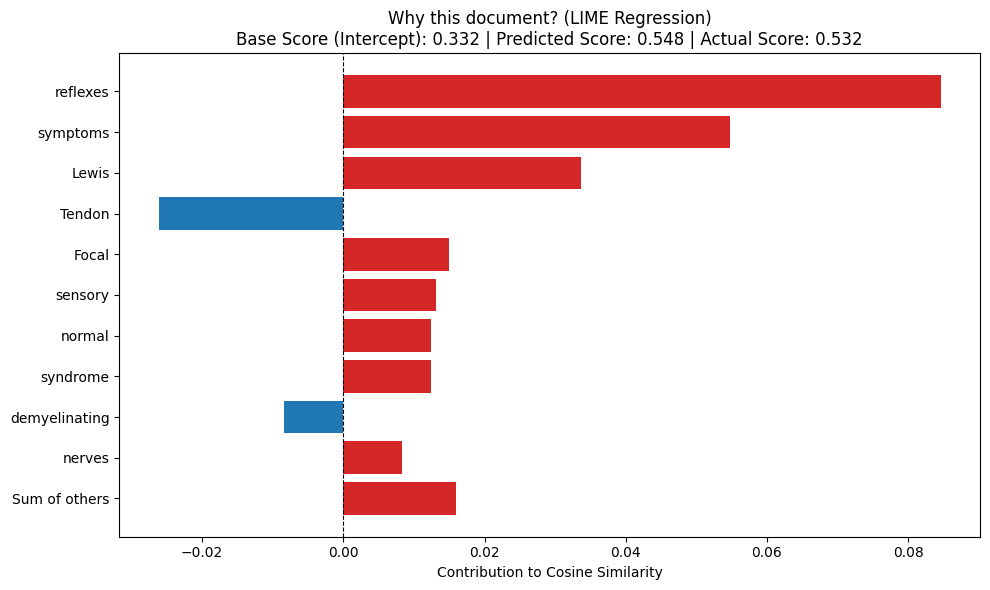

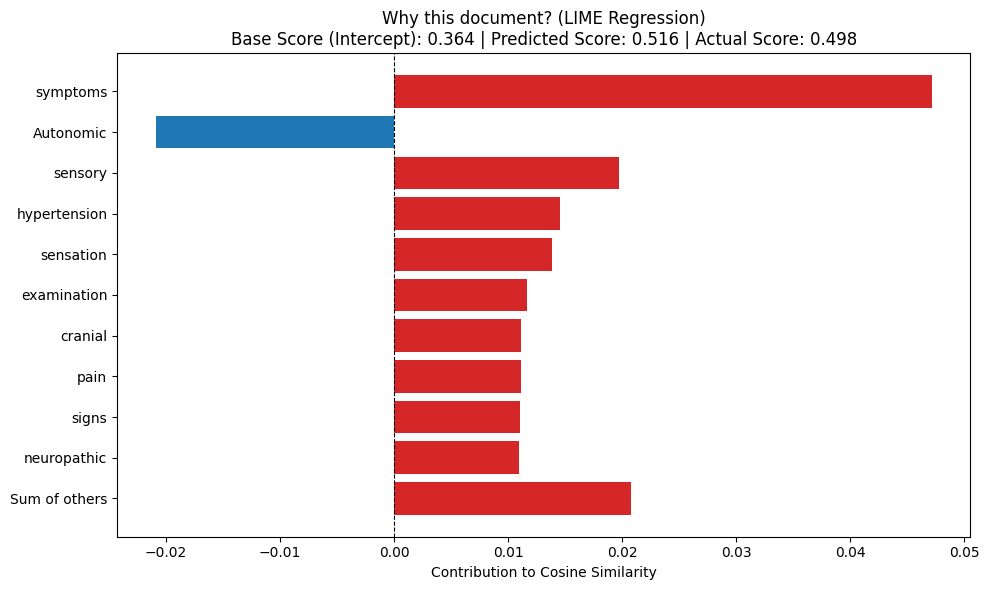

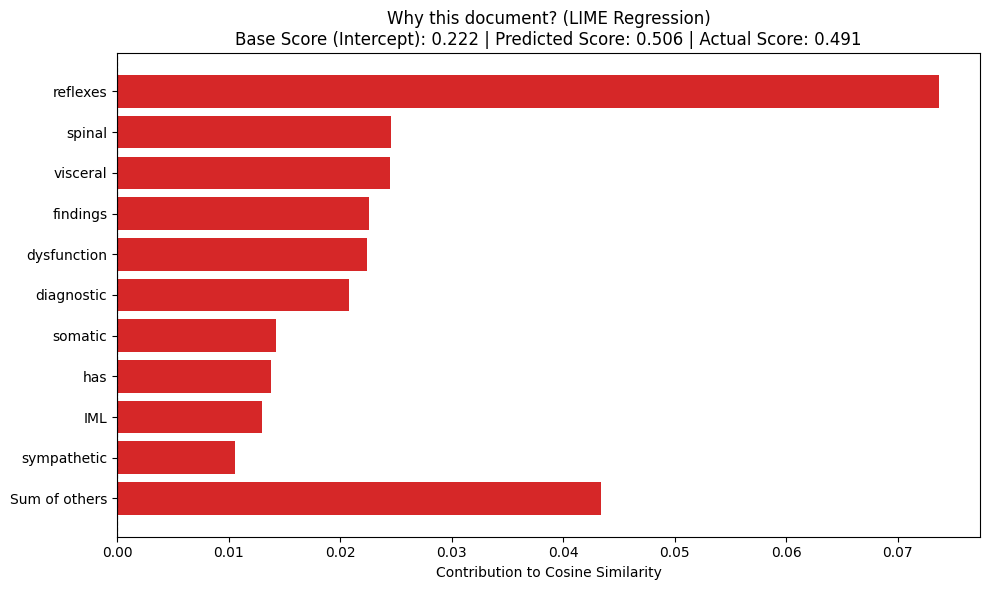

In [34]:
# plot tow example questions (same as shap)
display_results(lime_explainer, lime_explanations[:2])

## 4. Comparing Lime and Shap

We will now compare, how the Shap and Lime values differ from each other for all observed documents.

In [18]:
def strip_regex(text):
    # Regex pattern matching any of the specified characters
    return re.sub(r"[\(\)\[\]\{\}\'\"]", "", text)

comparison_data = []

for question_shap, question_lime in zip(shap_explanations, lime_explanations):

    explanation_hop_shap = question_shap["explanation"]
    explanation_hop_lime = question_lime["explanation"]

    for hop_shap, hop_lime in zip(explanation_hop_shap.values(), explanation_hop_lime.values()): 

        for document_explanation_shap, document_explanation_lime in zip(hop_shap, hop_lime):

            shap_vals = document_explanation_shap["shap_values"]
            shap_words = document_explanation_shap["tokens"]

            lime_dic = dict(document_explanation_lime["explanation_tuples"])
            lime_dic = {strip_regex(k.lower().strip()):v for k,v in lime_dic.items()}

            for word, s_score in zip(shap_words, shap_vals):
                l_score = lime_dic.get(word.strip(), 0.0) 
                
                comparison_data.append({
                    "Word": word,
                    "SHAP": s_score,
                    "LIME": l_score,
                    "Difference": abs(s_score - l_score)
                })

df_compare = pd.DataFrame(comparison_data)

print("Top Disagreements:")
print(df_compare.sort_values(by="Difference", ascending=False).head(20))


Top Disagreements:
             Word      SHAP      LIME  Difference
6863      cardiac  0.312774  0.009255    0.303520
9267  tachycardia  0.207567  0.002448    0.205120
9181  tachycardia  0.198699  0.000000    0.198699
5204      lithium  0.101170  0.256922    0.155751
5185      lithium  0.101586  0.256922    0.155336
2334  clostridium  0.000000  0.154635    0.154635
4268     grafting  0.149829  0.000000    0.149829
1594  clostridium  0.000000  0.147685    0.147685
6377     nitrates  0.088908  0.235039    0.146131
6379     nitrates  0.091543  0.235039    0.143496
5167      lithium  0.119704  0.256922    0.137218
6310       lumbar  0.129355  0.000000    0.129355
8256         pain  0.039195  0.167972    0.128777
2498  clostridium  0.241714  0.113606    0.128108
2344     diarrhea  0.000000  0.121731    0.121731
4772      lithium  0.075948  0.196835    0.120887
8290         pain  0.047887  0.167972    0.120085
4791      lithium  0.077329  0.196835    0.119506
3711      basilar  0.061316  0.

In [27]:
print(f"{sum(abs(df_compare['SHAP']) != 0)} / {len(df_compare)}")

828 / 9446


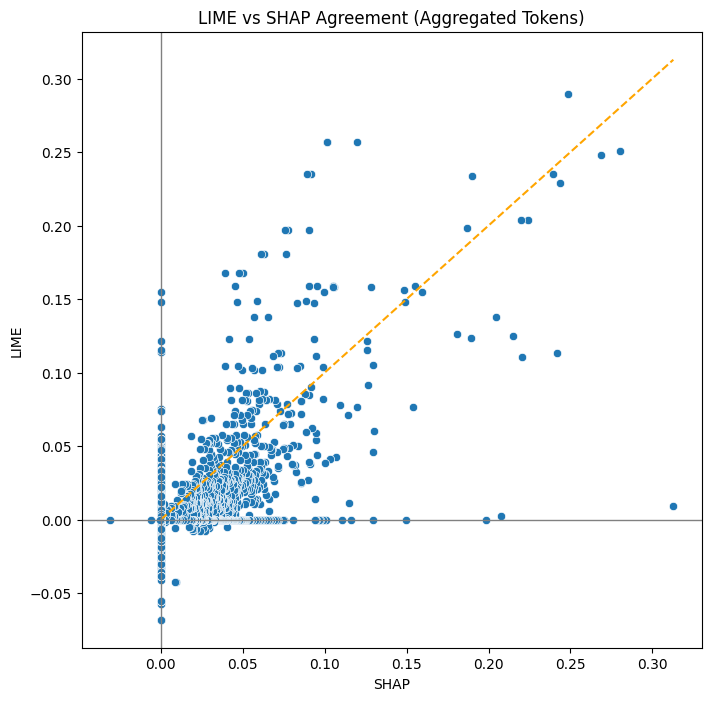

In [20]:
df_compare_plot = df_compare.sort_values(by="SHAP", ascending=False)

plt.figure(figsize=(8, 8))
sns.scatterplot(data=df_compare_plot, x="SHAP", y="LIME")

# Add a diagonal line (perfect agreement)
plt.plot([0, max(df_compare["SHAP"])], [0, max(df_compare["SHAP"])], color='orange', linestyle='--')

plt.title("LIME vs SHAP Agreement (Aggregated Tokens)")
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.show()

### Evaluating Explanations

Since we are explaining a simple Bert-Based Embedding Model, it would be interesting to observe how often a ranking of the documents was based on a simple token matching with the query and when ...

In [22]:
# plural Engine
p = inflect.engine()

match_count_shap = 0
amount_shap_values = 0

for question in shap_explanations:

    explanation_hop = question["explanation"]

    for hop in explanation_hop.values():  

        for document_explanation in hop:

            print(f"\n{'Query Word':<15} | {'Matched Key':<15} | {'SHAP Value':<10} | {'Result'}")
            print("-" * 60)

            shap_vals = document_explanation["shap_values"]
            shap_words = document_explanation["tokens"]
            shap_lookup = defaultdict(float)
            for word, val in zip(shap_words, shap_vals):
                shap_lookup[word.lower().strip()] += val
            query = document_explanation["query"] # the query stays the same

            amount_shap_values += len([val for val in shap_vals if val != 0])

            for word in query.split():
                
                clean_word = strip_regex(word.strip().lower())
                
                # try exact match first
                match_key = None
                if clean_word in shap_lookup:
                    match_key = clean_word
                
                # if no exact match, try plural and singular form
                else:
                    plural_word = p.plural_noun(clean_word)
                    singular_word = p.singular_noun(clean_word)
                    
                    if plural_word and plural_word in shap_lookup:
                        match_key = plural_word

                    elif singular_word and singular_word in shap_lookup:
                        match_kex = singular_word
                        
                if match_key:
                    shap_val = shap_lookup[match_key]
                    
                    if shap_val != 0:
                        print(f"{clean_word:<15} | {match_key:<15} | {shap_val:<10.2f} | Match!")
                        match_count_shap += 1
                    else:
                        print(f"{clean_word:<15} | {match_key:<15} | {shap_val:<10.2f} | Value too low")
                else:
                    print(f"{clean_word:<15} | {'None':<15} | {'-':<10} | Not in Doc")


Query Word      | Matched Key     | SHAP Value | Result
------------------------------------------------------------
childhood       | None            | -          | Not in Doc
osteopetrosis   | osteopetrosis   | 0.12       | Match!
is              | None            | -          | Not in Doc
characterized   | None            | -          | Not in Doc
by              | None            | -          | Not in Doc
–               | None            | -          | Not in Doc
a               | None            | -          | Not in Doc
b/l             | None            | -          | Not in Doc
frontal         | None            | -          | Not in Doc
bossingb        | None            | -          | Not in Doc
multiple        | None            | -          | Not in Doc
#               | None            | -          | Not in Doc
fracturec       | None            | -          | Not in Doc
hepatosplenomegalyd | None            | -          | Not in Doc
cataracte       | None            | -     

Now we can calculate the matches across all query document pairs to find the ratios.

In [23]:
print(f"Amount of Shap Values (!= 0): {amount_shap_values} | Ratio Token matching: {(match_count_shap / amount_shap_values*100):.2f}%")

Amount of Shap Values (!= 0): 828 | Ratio Token matching: 18.60%


This does not include observed matches, where verbs and nouns (e.g. **teach** and **teach**er) are matched or similarly words have sub-words contained within eachother (e.g.anti**biotics** and pro**biotics**).

The same thing we can apply to LIME, here we will observe every token that gets a value of atleast 0.01, since LIME values are never zero.

In [24]:
match_count_lime = 0
amount_lime_values = 0

p = inflect.engine()

for question in lime_explanations:

    explanation_hop = question["explanation"]

    for hop in explanation_hop.values():  

        for document_explanation in hop:

            print(f"\n{'Query Word':<15} | {'Matched Key':<15} | {'SHAP Value':<10} | {'Result'}")
            print("-" * 60)

            lime_vals = [v for k,v in document_explanation["explanation_tuples"]]
            lime_words = [k for k,v in document_explanation["explanation_tuples"]]
            lime_lookup = defaultdict(float)
            for word, val in zip(lime_words, lime_vals):
                word = strip_regex(word.lower())
                lime_lookup[word.strip()] += val
            query = document_explanation["query"] # the query stays the same

            amount_lime_values += len([val for val in lime_vals if abs(val) >= 0.01])

            for word in query.split():
                
                clean_word = strip_regex(word.strip().lower())
                
                # try exact match first
                match_key = None
                if clean_word in lime_lookup:
                    match_key = clean_word
                
                # if no exact match, try plural and singular form
                else:
                    plural_word = p.plural_noun(clean_word)
                    singular_word = p.singular_noun(clean_word)
                    
                    if plural_word and plural_word in lime_lookup:
                        match_key = plural_word

                    elif singular_word and singular_word in lime_lookup:
                        match_kex = singular_word
                        
                if match_key:
                    lime_val = lime_lookup[match_key]
                    
                    if abs(lime_val) >= 0.01:
                        print(f"{clean_word:<15} | {match_key:<15} | {lime_val:<10.2f} | Match!")
                        match_count_lime += 1
                    else:
                        print(f"{clean_word:<15} | {match_key:<15} | {lime_val:<10.2f} | Value too low")
                else:
                    print(f"{clean_word:<15} | {'None':<15} | {'-':<10} | Not in Doc")


Query Word      | Matched Key     | SHAP Value | Result
------------------------------------------------------------
childhood       | None            | -          | Not in Doc
osteopetrosis   | osteopetrosis   | 0.08       | Match!
is              | None            | -          | Not in Doc
characterized   | None            | -          | Not in Doc
by              | None            | -          | Not in Doc
–               | None            | -          | Not in Doc
a               | None            | -          | Not in Doc
b/l             | None            | -          | Not in Doc
frontal         | None            | -          | Not in Doc
bossingb        | None            | -          | Not in Doc
multiple        | None            | -          | Not in Doc
#               | None            | -          | Not in Doc
fracturec       | None            | -          | Not in Doc
hepatosplenomegalyd | None            | -          | Not in Doc
cataracte       | None            | -     

In [25]:
print(f"Amount of LIME Values (>=0.01): {amount_lime_values} | Ratio Token matching: {(match_count_lime / amount_lime_values*100):.2f}%")

Amount of LIME Values (>=0.01): 1101 | Ratio Token matching: 16.53%
